# Viterbi

In [1]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyro import poutine
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta

In [6]:
data = pd.read_csv("../data/hulls_df_compact_matchday2.csv")

data = data.dropna()
data.head()

,Time [s],Period,HomeHull,AwayHull
0,2.0,1.0,584.492054,789.046673
1,3.0,1.0,610.435976,831.996092
2,4.0,1.0,642.984305,917.031595
3,5.0,1.0,651.063432,972.127810
4,6.0,1.0,667.510469,1036.001978


## Univariate Model

In [27]:
def gamma_viterbi_decoder(data, transition_matrix, shape_params, rate_params):
    """
    Performs Viterbi decoding for a Gamma HMM.

    Parameters:
    data (list or array): The observations.
    hidden_dim (int): Number of hidden states.
    transition_matrix (torch.Tensor): The state transition probabilities.
    shape_params (torch.Tensor): The shape parameters of the Gamma distributions.
    rate_params (torch.Tensor): The rate parameters of the Gamma distributions.

    Returns:
    list: The most likely sequence of hidden states.
    """
    hidden_dim= len(shape_params)
    states = [np.random.randint(low=0,high=hidden_dim)]
    for t in pyro.markov(range(len(data))):
        states.append(pyro.sample("states_{}".format(t),
                                  dist.Categorical(transition_matrix[states[-1]])))
        pyro.sample("obs_{}".format(t),
                    dist.Gamma(shape_params[states[-1]], rate_params[states[-1]]),
                    obs=data[t])
    return states[1:]  # returns the most likely states

### Home Hull

In [28]:
x_sequence = torch.tensor(data["HomeHull"].values)

In [29]:
posterior=torch.load("parameters/singleHMM_home.pt")
posterior

{'probs_x': tensor([[0.9631, 0.0369],
         [0.0634, 0.9366]], requires_grad=True),
 'probs_alpha': tensor([  5.5652, 120.9643], requires_grad=True),
 'probs_beta': tensor([0.0063, 0.1008], requires_grad=True)}

In [30]:
transition_matrix = torch.tensor([[0.9631, 0.0369],
                                  [0.0634, 0.9366]])
shape_params = torch.tensor([ 5.5652, 120.9643])  
rate_params = torch.tensor([0.0063, 0.1008]) 

hidden_states = gamma_viterbi_decoder(x_sequence, transition_matrix=transition_matrix, shape_params=shape_params, rate_params=rate_params)

In [31]:
most_likely_states_H = np.array([int(state) for state in hidden_states])
data["HomeMLS"]=most_likely_states_H

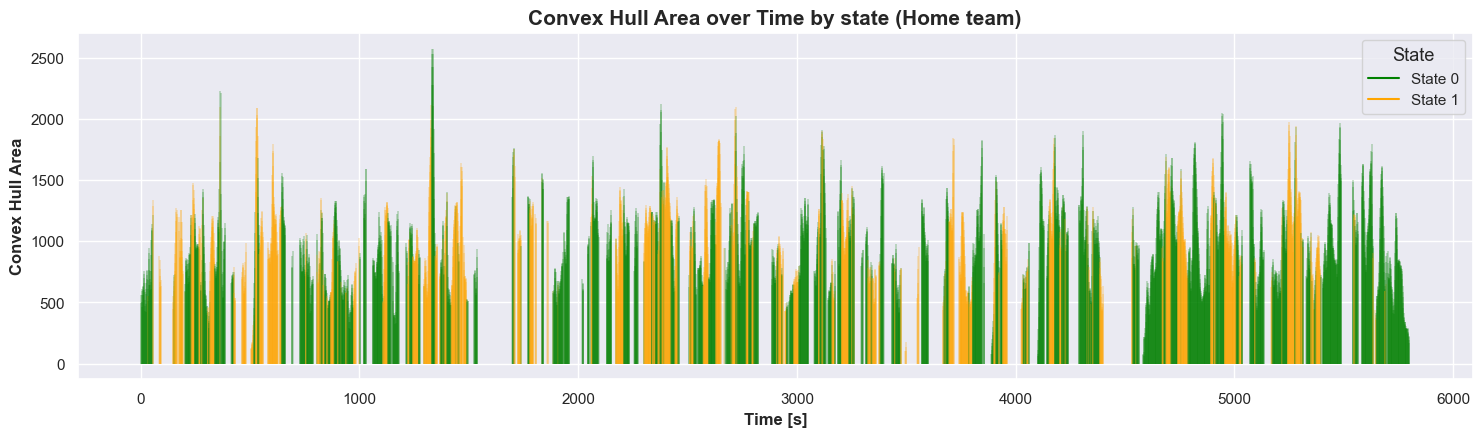

In [32]:
class_colors = {
    0: 'green',
    1: 'orange'
}
colors = data['HomeMLS'].map(class_colors)

plt.figure(figsize=(18, 4.5))
plt.vlines(data["Time [s]"], ymin=0, ymax=data["HomeHull"], color=colors,linewidth=0.3)
plt.xlabel("Time [s]", fontsize=12, fontweight='bold');
plt.ylabel("Convex Hull Area", fontsize=12, fontweight='bold');
plt.title("Convex Hull Area over Time by state (Home team)", fontsize=15, fontweight='bold');

# Creating legend manually since automatic legend does not work well with vlines
for i, state in enumerate([0,1]):
    plt.plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')

plt.legend(title="State", title_fontsize='13', fontsize='11', loc='upper right');
plt.savefig("../plots/UnivariateHMM_MostLikelySeq_HomeTeam_matchday1.png",dpi=350)

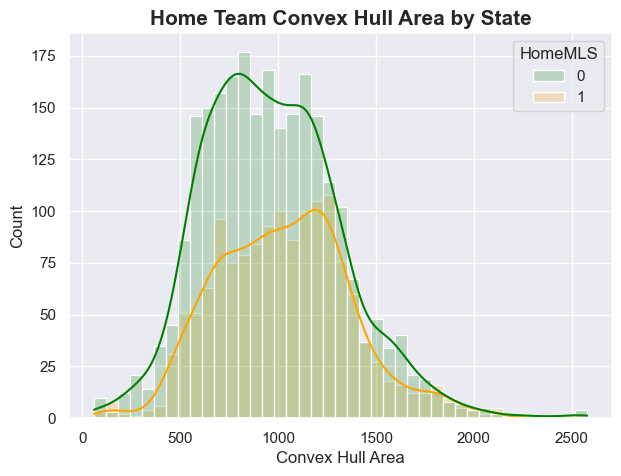

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(data, x="HomeHull", hue="HomeMLS", kde=True, palette=class_colors,alpha=0.2)
ax.set_xlabel("Convex Hull Area", fontsize=12, fontweight='normal');
ax.set_ylabel("Count", fontsize=12, fontweight='normal');
ax.set_title("Home Team Convex Hull Area by State", fontsize=15, fontweight='bold');
fig.savefig("../plots/UnivariateHMM_StateDistribution_HomeTeam_matchday1.png",dpi=350)

### Away Hull

In [34]:
y_sequence = torch.tensor(data["AwayHull"].values)

In [35]:
posterior=torch.load("parameters/singleHMM_away.pt")
posterior

{'probs_x': tensor([[0.9672, 0.0328],
         [0.0506, 0.9494]], requires_grad=True),
 'probs_alpha': tensor([ 6.5119, 35.4986], requires_grad=True),
 'probs_beta': tensor([0.0058, 0.0493], requires_grad=True)}

In [36]:
transition_matrix = torch.tensor([[0.9672, 0.0328],
                                  [0.0506, 0.9494]])
shape_params = torch.tensor([ 6.5119, 35.4986])  
rate_params = torch.tensor([0.0058, 0.0493]) 

hidden_states = gamma_viterbi_decoder(x_sequence, transition_matrix=transition_matrix, shape_params=shape_params, rate_params=rate_params)

In [37]:
most_likely_states_A = np.array([int(state) for state in hidden_states])
data["AwayMLS"]=most_likely_states_A

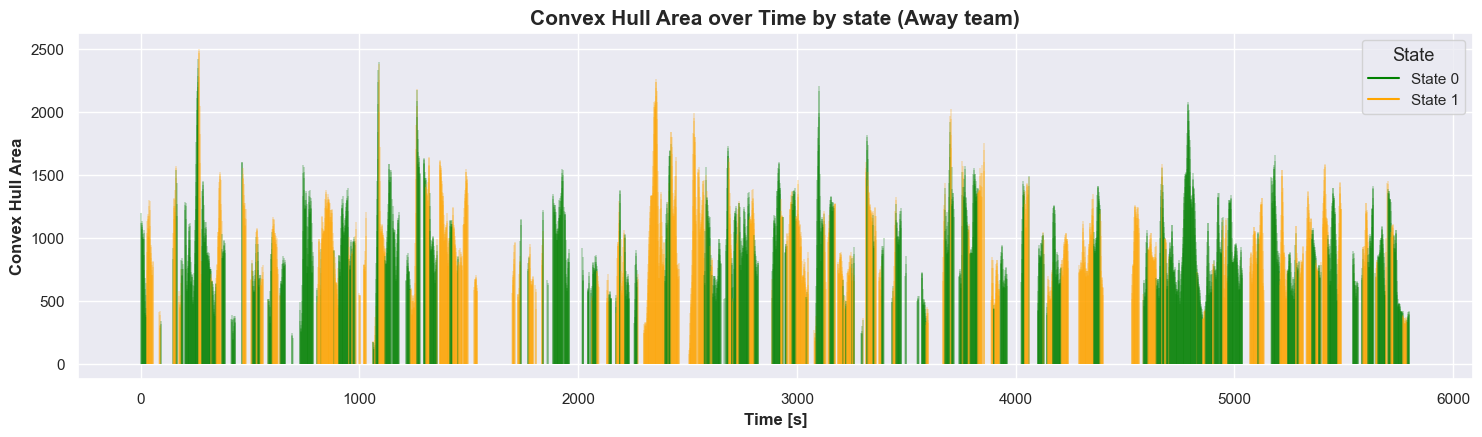

In [38]:
class_colors = {
    0: 'green',
    1: 'orange'
}
colors = data['AwayMLS'].map(class_colors)

plt.figure(figsize=(18, 4.5))
plt.vlines(data["Time [s]"], ymin=0, ymax=data["AwayHull"], color=colors,linewidth=0.3)
plt.xlabel("Time [s]", fontsize=12, fontweight='bold');
plt.ylabel("Convex Hull Area", fontsize=12, fontweight='bold');
plt.title("Convex Hull Area over Time by state (Away team)", fontsize=15, fontweight='bold');

# Creating legend manually since automatic legend does not work well with vlines
for i, state in enumerate([0,1]):
    plt.plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')

plt.legend(title="State", title_fontsize='13', fontsize='11', loc='upper right');
plt.savefig("../plots/UnivariateHMM_MostLikelySeq_AwayTeam_matchday1.png",dpi=350)

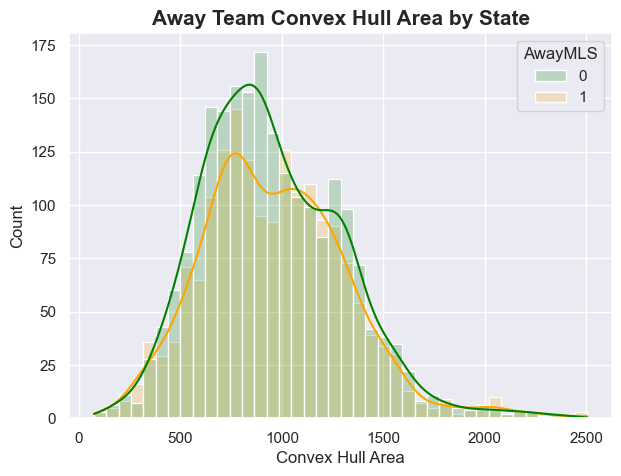

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(data, x="AwayHull", hue="AwayMLS", kde=True, palette=class_colors,alpha=0.2)
ax.set_xlabel("Convex Hull Area", fontsize=12, fontweight='normal');
ax.set_ylabel("Count", fontsize=12, fontweight='normal');
ax.set_title("Away Team Convex Hull Area by State", fontsize=15, fontweight='bold');
fig.savefig("../plots/UnivariateHMM_StateDistribution_AwayTeam_matchday1.png",dpi=350)

### Bivariate Model

In [24]:
data = pd.read_csv("../data/hulls_every2_matchday2.csv")
data = data.dropna()
events=pd.read_csv("../data/events_matchday2.csv")
goals_info=events[events["Subtype"].isin(["ON TARGET-GOAL","HEAD-ON TARGET-GOAL","WOODWORK-GOAL"])]
home_goals=goals_info[goals_info["Team"]=="Home"]
away_goals=goals_info[goals_info["Team"]=="Away"]

In [5]:
def empirical_gamma_cdf(x, shape, rate):
    # Generate 1000 random samples from the gamma distribution
    # Think about setting a seed to avoid too much stochasticity
    #torch.manual_seed(3407)
    samples = torch.distributions.Gamma(shape, rate).sample((3500,))
    return (samples <= x).float().mean()

def copula_term_log(theta: torch.tensor, u: torch.tensor, v: torch.tensor):
    log_numerator = torch.log(theta) + torch.log(torch.exp(theta) - 1.0) + theta * (1.0 + u + v)
    denominator = (torch.exp(theta) - torch.exp(theta + theta * u) + torch.exp(theta * (u + v)) - torch.exp(theta + theta * v))**2
    log_denominator = torch.log(denominator)
    return log_numerator - log_denominator

def copulamodel_log_pdf(x,y,shape1,rate1,shape2,rate2,theta):
    g1_lpdf= dist.Gamma(shape1,rate1).log_prob(x)
    g2_lpdf= dist.Gamma(shape2,rate2).log_prob(y)
    u= empirical_gamma_cdf(x, shape1, rate1)
    v= empirical_gamma_cdf(y, shape2, rate2)
    # Qui pensare se fare una if su u e v diversi da circa 0...in quel caso non calcolare il copula term (lo lascio nullo)
    lpdf=g1_lpdf+g2_lpdf
    if (torch.abs(u) > 1e-6) & (torch.abs(v) > 1e-6):
        lpdf += copula_term_log(theta=theta,u=u,v=v)
    return lpdf

In [6]:
def gamma_viterbi_decoder_copula(data, transition_matrix, shape_params1, rate_params1,shape_params2, rate_params2,theta):
    """
    Performs Viterbi decoding for a Gamma HMM.

    Parameters:
    data (list or array): The observations.
    hidden_dim (int): Number of hidden states.
    transition_matrix (torch.Tensor): The state transition probabilities.
    shape_params (torch.Tensor): The shape parameters of the Gamma distributions.
    rate_params (torch.Tensor): The rate parameters of the Gamma distributions.

    Returns:
    list: The most likely sequence of hidden states.
    """
    hidden_dim= transition_matrix.shape[0]
    states = [np.random.randint(low=0,high=hidden_dim)]
    for t in pyro.markov(range(len(data))):
        states.append(pyro.sample("states_{}".format(t),
                                  dist.Categorical(transition_matrix[states[-1]])))
        # pyro.sample("obs_{}".format(t),
        #             dist.Gamma(shape_params[states[-1]], rate_params[states[-1]]),
        #             obs=data[t])
        log_pdf = copulamodel_log_pdf(
            x=data[t,0],
            y=data[t,1],
            shape1=shape_params1[states[-1]],
            rate1=rate_params1[states[-1]],
            shape2=shape_params2[states[-1]],
            rate2=rate_params2[states[-1]],
            theta=theta[states[-1]]
        )
        pyro.factor(f"xy_{t}", log_pdf)
    return states[1:]  # returns the most likely states


Import the data:

In [7]:
xy_sequence = torch.tensor(data[["HomeHull","AwayHull"]].values/100)
xy_sequence.shape

torch.Size([1970, 2])

Import the parametes estimated via Variational Inference:

In [8]:
posterior=torch.load("parameters/doubleHMM_4states_matchday2_every2sec.pt")
posterior

{'probs_x': tensor([[0.8516, 0.0358, 0.0887, 0.0239],
         [0.0233, 0.9129, 0.0251, 0.0387],
         [0.0158, 0.0269, 0.9339, 0.0234],
         [0.0120, 0.0526, 0.0476, 0.8878]], requires_grad=True),
 'probs_alpha1': tensor([ 5.7242, 10.2903, 17.4644, 14.0914], requires_grad=True),
 'probs_beta1': tensor([0.9758, 1.6586, 1.6569, 1.3222], requires_grad=True),
 'probs_alpha2': tensor([ 6.2696, 13.1638, 16.5609, 13.3948], requires_grad=True),
 'probs_beta2': tensor([1.3575, 1.1748, 2.3969, 1.0639], requires_grad=True),
 'theta': tensor([2.7437, 0.9762, 0.8987, 4.6567], requires_grad=True)}

In [9]:
transition_matrix = posterior["probs_x"]
shape_params1 = posterior["probs_alpha1"]
rate_params1 = posterior["probs_beta1"]
shape_params2 = posterior["probs_alpha2"] 
rate_params2 = posterior["probs_beta2"]
theta= posterior["theta"]


hidden_states = gamma_viterbi_decoder_copula(data=xy_sequence,
                                      transition_matrix=transition_matrix,
                                      shape_params1=shape_params1,
                                      rate_params1=rate_params1,
                                      shape_params2=shape_params2,
                                      rate_params2=rate_params2,
                                      theta=theta
                                      )

In [10]:
most_likely_states = np.array([int(state) for state in hidden_states])
data["HomeMLS"]=most_likely_states
data["AwayMLS"]=most_likely_states

In [11]:
class_colors = {
    0: 'green',
    1: 'orange',
    2: 'red',
    3: 'blue'
}
colors = data['AwayMLS'].map(class_colors)

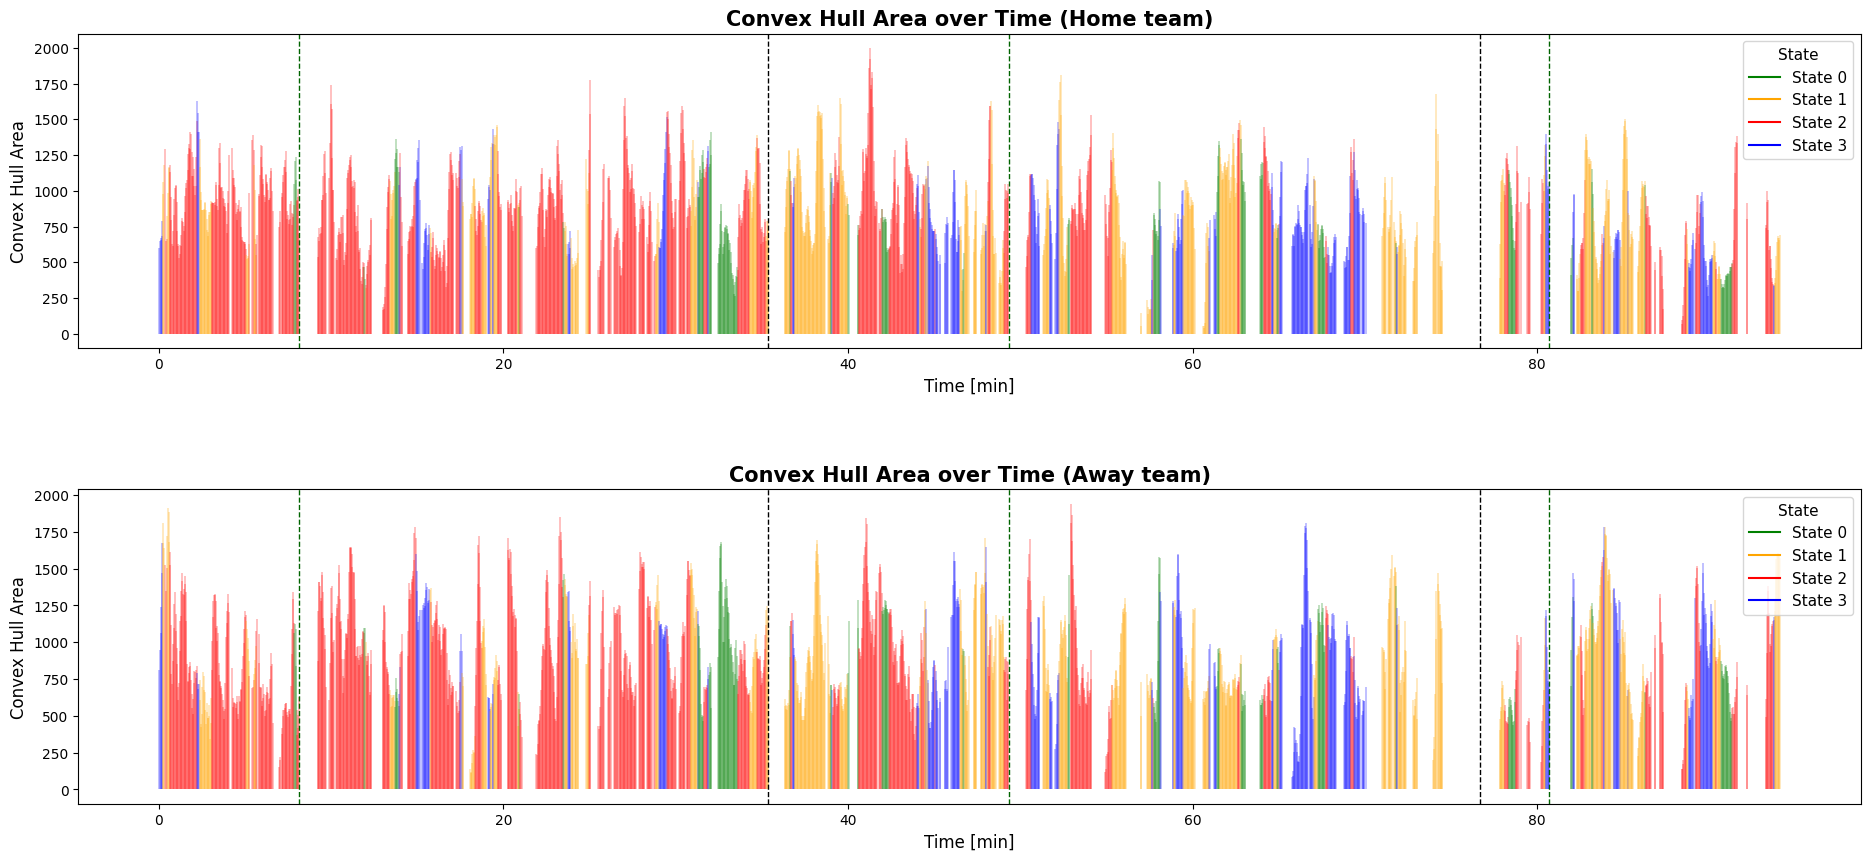

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(23, 10))
# Home team's convex hull area
axs[0].vlines(data["Time [s]"]/60, ymin=0, ymax=data["HomeHull"], color=colors, linewidth=0.35)
axs[0].set_xlabel("Time [min]", fontsize=12,fontweight='normal');
axs[0].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
axs[0].set_title("Convex Hull Area over Time (Home team)", fontsize=15, fontweight='bold');
# add legend
for i, state in enumerate([0,1,2,3]):
    axs[0].plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')
axs[0].legend(title="State", title_fontsize='11', fontsize='11', loc='upper right');

# Away team's convex hull area
axs[1].vlines(data["Time [s]"]/60, ymin=0, ymax=data["AwayHull"],color=colors, linewidth=0.35)
axs[1].set_xlabel("Time [min]", fontsize=12,fontweight='normal');
axs[1].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
axs[1].set_title("Convex Hull Area over Time (Away team)", fontsize=15, fontweight='bold');
for i, state in enumerate([0,1,2,3]):
    axs[1].plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')
axs[1].legend(title="State", title_fontsize='11', fontsize='11', loc='upper right');

# # add vertical lines for home goals
for t1,t2 in zip(home_goals["Start Time [s]"]/60,home_goals["End Time [s]"]/60):
    axs[0].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=1) 
    axs[1].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=1)
# add vertical lines for away goals
for t1,t2 in zip(away_goals["Start Time [s]"]/60,away_goals["End Time [s]"]/60):
    axs[0].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=1) 
    axs[1].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=1)
# Manage space between subplots
plt.subplots_adjust(hspace=0.45)
plt.savefig("../plots/BivariateHMM_MostLikelySeq_matchday2_every2.png",dpi=350, bbox_inches='tight')

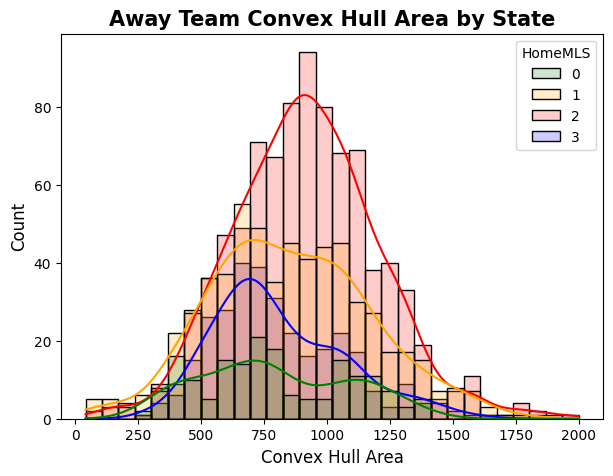

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(data, x="HomeHull", hue="HomeMLS", kde=True, palette=class_colors,alpha=0.2)
ax.set_xlabel("Convex Hull Area", fontsize=12, fontweight='normal');
ax.set_ylabel("Count", fontsize=12, fontweight='normal');
ax.set_title("Away Team Convex Hull Area by State", fontsize=15, fontweight='bold');

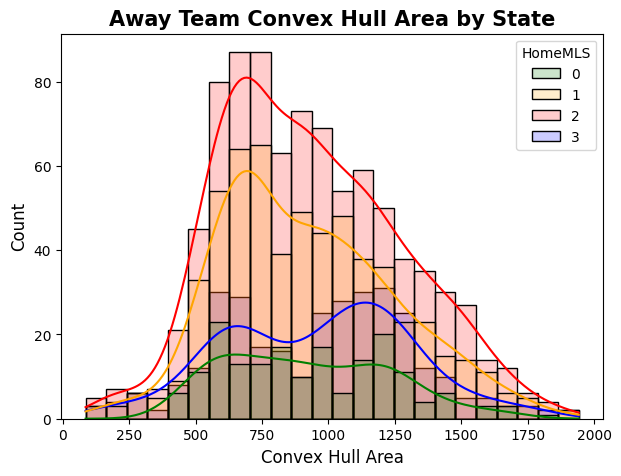

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(data, x="AwayHull", hue="HomeMLS", kde=True, palette=class_colors,alpha=0.2)
ax.set_xlabel("Convex Hull Area", fontsize=12, fontweight='normal');
ax.set_ylabel("Count", fontsize=12, fontweight='normal');
ax.set_title("Away Team Convex Hull Area by State", fontsize=15, fontweight='bold');

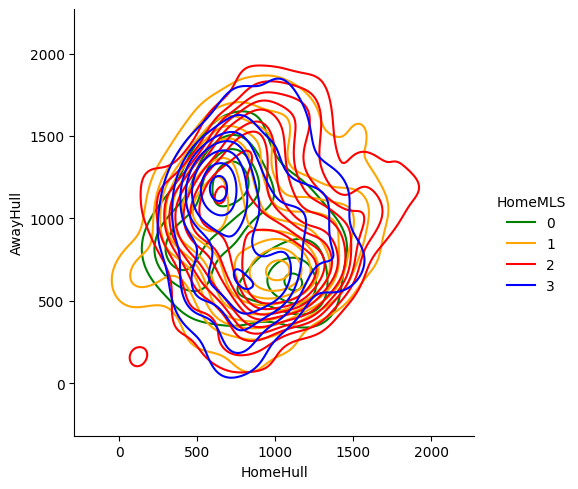

In [20]:
sns.displot(data, x="HomeHull", y="AwayHull", hue="HomeMLS", kind="kde", palette=class_colors)

---

# Trial with compute marginals

In [8]:
elbo = TraceEnum_ELBO(max_plate_nesting=1)
def model(sequence, hidden_dim, include_prior=True):
    n_obs = sequence.shape[0]
    with poutine.mask(mask=include_prior):
        #---------------------------------------------------------------------
        # Transition probabilities
        probs_x = pyro.sample(
            "probs_x",
            dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(),
        )
        #---------------------------------------------------------------------
        # Prior for the parameters of emission probabilities 
        probs_alpha1 = pyro.sample(
            "probs_alpha1",
            dist.Gamma(concentration=15.0,rate=0.8).expand([hidden_dim]).to_event(1)
        )

        probs_beta1 = pyro.sample(
            "probs_beta1",
            dist.Gamma(concentration=1.0,rate=1.0).expand([hidden_dim]).to_event(1)
        )
        probs_alpha2 = pyro.sample(
            "probs_alpha2",
            dist.Gamma(concentration=15.0,rate=0.8).expand([hidden_dim]).to_event(1)
        )

        probs_beta2 = pyro.sample(
            "probs_beta2",
            dist.Gamma(concentration=1.0,rate=1.0).expand([hidden_dim]).to_event(1)
        )
        #---------------------------------------------------------------------
        # Prior for theta
        theta = pyro.sample(
            "theta",
            dist.Gamma(5.0,0.7).expand([hidden_dim]).to_event(1)
        )
        
    
    x = 0  # Initial hidden state
    for t in pyro.markov(range(n_obs)):
        x = pyro.sample(
            f"x_{t}",
            dist.Categorical(probs_x[x]),
            infer={"enumerate": "parallel"},
        )
        log_pdf = copulamodel_log_pdf(
            x=sequence[t,0],
            y=sequence[t,1],
            shape1=probs_alpha1[x],
            rate1=probs_beta1[x],
            shape2=probs_alpha2[x],
            rate2=probs_beta2[x],
            theta=theta[x]
        )
        pyro.factor(f"xy_{t}", log_pdf)
        

guide = AutoDelta(poutine.block(model, expose=["probs_x",
                                               "probs_alpha1",
                                               "probs_beta1",
                                               "probs_alpha2",
                                               "probs_beta2",
                                               "theta"
                                               ]))

In [14]:
posterior=torch.load("parameters/doubleHMM_4states_matchday2.pt")
posterior

{'probs_x': tensor([[0.7626, 0.0832, 0.0679, 0.0863],
         [0.0218, 0.9550, 0.0119, 0.0113],
         [0.0431, 0.0220, 0.9174, 0.0176],
         [0.0217, 0.0097, 0.0040, 0.9646]], requires_grad=True),
 'probs_alpha1': tensor([13.2520, 11.9796,  7.1448, 27.8372], requires_grad=True),
 'probs_beta1': tensor([1.7740, 1.3901, 1.5781, 2.5842], requires_grad=True),
 'probs_alpha2': tensor([14.7016, 45.5051,  8.4511, 11.6120], requires_grad=True),
 'probs_beta2': tensor([1.7090, 3.4527, 1.0032, 1.7175], requires_grad=True),
 'theta': tensor([9.6124, 1.5562, 1.5354, 0.2037], requires_grad=True)}

In [19]:
pyro.param("probs_x", posterior["probs_x"])
pyro.param("probs_alpha1", posterior["probs_alpha1"])
pyro.param("probs_beta1", posterior["probs_beta1"])
pyro.param("probs_alpha2", posterior["probs_alpha2"])
pyro.param("probs_beta2", posterior["probs_beta2"])
pyro.param("theta", posterior["theta"])

tensor([9.6124, 1.5562, 1.5354, 0.2037], requires_grad=True)

In [ ]:
marginals= elbo.compute_marginals(model,guide,xy_sequence,4)